In [1]:
import os
from tqdm import tqdm
import numpy as np
os.listdir('../weis/')

from datetime import datetime

['cb']

In [2]:
# Load configuration from environment variables
symbol = os.getenv('SYMBOL')
interval = int(os.getenv('INTERVAL'))
tss_n_splits = int(os.getenv('TSS_N_SPLITS'))
n_back_features = int(os.getenv('N_BACK_FEATURES'))
tss_test_size = int(os.getenv('TSS_TEST_SIZE'))

['schedule.py', 'predict.py', 'train.py', 'utils', 'pipeline.py', 'parsing', 'backtest.ipynb', '.ipynb_checkpoints', '__pycache__']


In [33]:
from train import parse_and_preprocess_data, preprocess_for_training
from predict import ModelPrediction

parsing_params = {
    'category': 'linear',
    'symbol': symbol,
    'interval': interval,
    'testnet': False,
    'start_date': datetime(2024, 8, 5),
    'end_date': datetime.now()
}

backtest_data = parse_and_preprocess_data(parsing_params, False)
X, _, _ = preprocess_for_training(backtest_data)
backtest_data = backtest_data.iloc[-len(X):].reset_index(drop=True)
print(X.shape)

(1760, 196)


In [34]:
prediction_model = ModelPrediction(
        model_path='../weis/cb',
        verbose=False
).model

preds = prediction_model.predict_proba(X)


In [42]:
buy_probas = [x[0] for x in preds]
sell_probas = [x[2] for x in preds]
hold_probas = [x[1] for x in preds]

ts = [0.67, 0, 0.67]

def make_decision(x, ts): 
    b, h, s = x
    if b > ts[0]:
        return 0
    elif s > ts[2]:
        return 2
    else:
        return 1

decisions = [make_decision(x, ts) for x in preds]

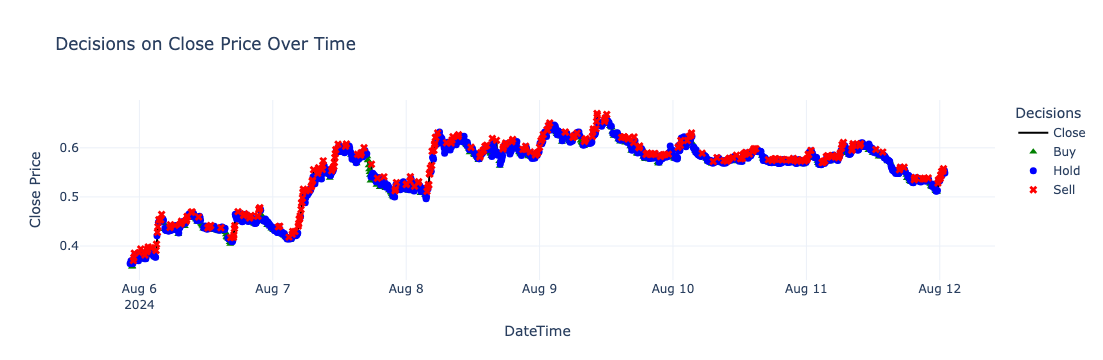

In [43]:
from utils.utils import *
    
plot_decisions_with_markers(datetimes=backtest_data['DATETIME'], closes=backtest_data['CLOSE'], decisions=decisions)

In [44]:
def backtest_strategy(decisions, initial_balance=10000, price_data=None, taker_fee=0.001, maker_fee=0.001):
    balance = initial_balance
    position = 0  # Current position: +1 for holding, 0 for no position
    transaction_log = []  # To keep track of all transactions

    for i, decision in enumerate(decisions):
        price = price_data[i] if price_data is not None else 100  # Assume a default price if not provided
        if decision == 0:  # Buy
            if position == 0:  # Only buy if not holding
                position = (balance / price) * (1 - taker_fee)  # Buy as much as possible minus fees
                balance = 0  # Spend all balance
                transaction_log.append(f"Buy at {price} with {taker_fee*100}% fee")
        elif decision == 2:  # Sell
            if position > 0:  # Only sell if holding
                balance = position * price * (1 - taker_fee)  # Sell all holdings minus fees
                position = 0  # Clear position
                transaction_log.append(f"Sell at {price} with {taker_fee*100}% fee")
        # No action needed for hold (1)

    # If still holding at the end, sell at the last price
    if position > 0:
        balance = position * price * (1 - taker_fee)  # Sell all at the last known price minus fees
        transaction_log.append(f"Final sell at {price} with {taker_fee*100}% fee")

    final_balance = balance
    roi = (final_balance - initial_balance) / initial_balance * 100

    return final_balance, roi


initial_balance = 100

# Run the backtest
final_balance, roi = backtest_strategy(decisions, initial_balance, backtest_data['CLOSE'])

print(roi)

26.786494596342663


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 517.81it/s]


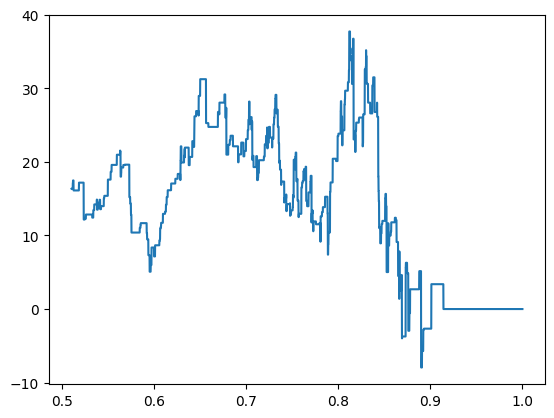

In [38]:
# Grid Search

all_tss, all_rois = [], []

for thresh in tqdm(np.linspace(0.51, 1.0, 10000)):
    tss = [thresh, 0, thresh]

    gs_decisions = [make_decision(x, tss) for x in preds]

    final_balance, roi = backtest_strategy(gs_decisions, initial_balance, backtest_data['CLOSE'])

    all_tss.append(thresh)
    all_rois.append(roi)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_tss, all_rois)
plt.show()
    